# Reliability performance measures

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

%matplotlib notebook

## Parameters

In [2]:
# data csv filename
data_csv = 'Podatki o prometu v Ljubljani 5 oktober - 8 november 2020.csv'
df = pd.read_csv(data_csv, encoding="utf8", skiprows=1)
# routes csv filename
routes_csv = 'routes 5 oktober - 8 november 2020.csv'
routes = pd.read_csv(routes_csv, encoding="utf8", skiprows=1)

# route id
# values: route ids in routes_csv -> [0,1,2,3,4,5,...]
route_id = 4
df_route = df.loc[df['route_id'] == route_id]
x = df_route['t_duration_in_traffic_[s]']/60

# free flow
free_flow = x.quantile(q=.05)
# failure threshold
# Failure threshold is the travel time corresponding to speed_threshold (in km/h).
# All travel times larger than failure threshold belong to the failure measure.
speed_threshold = 25

# histogram color
# values: matplotlib colors -> https://matplotlib.org/stable/gallery/color/named_colors.html
hist_col = 'blue'
# colors of vertical lines
v_col1 = 'violet'
v_col2 = 'purple'
# time measures color
times_col = 'deepskyblue'
# standard deviation color
std_col = 'maroon'
# semi-standard deviation color
semi_std_col = 'chocolate'
# failure measure color
fail_col = 'red'

# failure measure text position
# right offset from failure threshold
fail_offset = .5
# proportion of the histogram value on the right of failure threshold
fail_prop = 10

# figure size in inches
fig_length = 17
fig_height = 6
# save figure as rpm.pdf
# values: True or False
save_fig = True

## Functions

In [3]:
def vertical_line(x, ymax, text, text_horizontal_alignment, color):
    r"""Draws a vertical line from point (x, 0) to (x, .97*ymax)
    and puts text on top of the line."""
    plt.vlines(x, 0, .97*ymax, color=color, linestyle='dashed')
    ax.annotate(text, xy=(x, ymax), color=color,
                horizontalalignment=text_horizontal_alignment)


def horitontal_line(x1, x2, y, text, color):
    r"""Draws a horizontal line with arrows on each side
    from point (x1, y) to (x2, y) and puts text on the right side of the line."""
    ax.annotate(' '+text, xy=(x1, y), xytext=(x2, y), color=color, verticalalignment='center',
                arrowprops=dict(width=.5, headwidth=5, headlength=5, color=color))
    ax.annotate('', xy=(x2, y), xytext=(x1, y), color=color, verticalalignment='center',
                arrowprops=dict(width=.5, headwidth=5, headlength=5, color=color))

## Plot

<IPython.core.display.Javascript object>


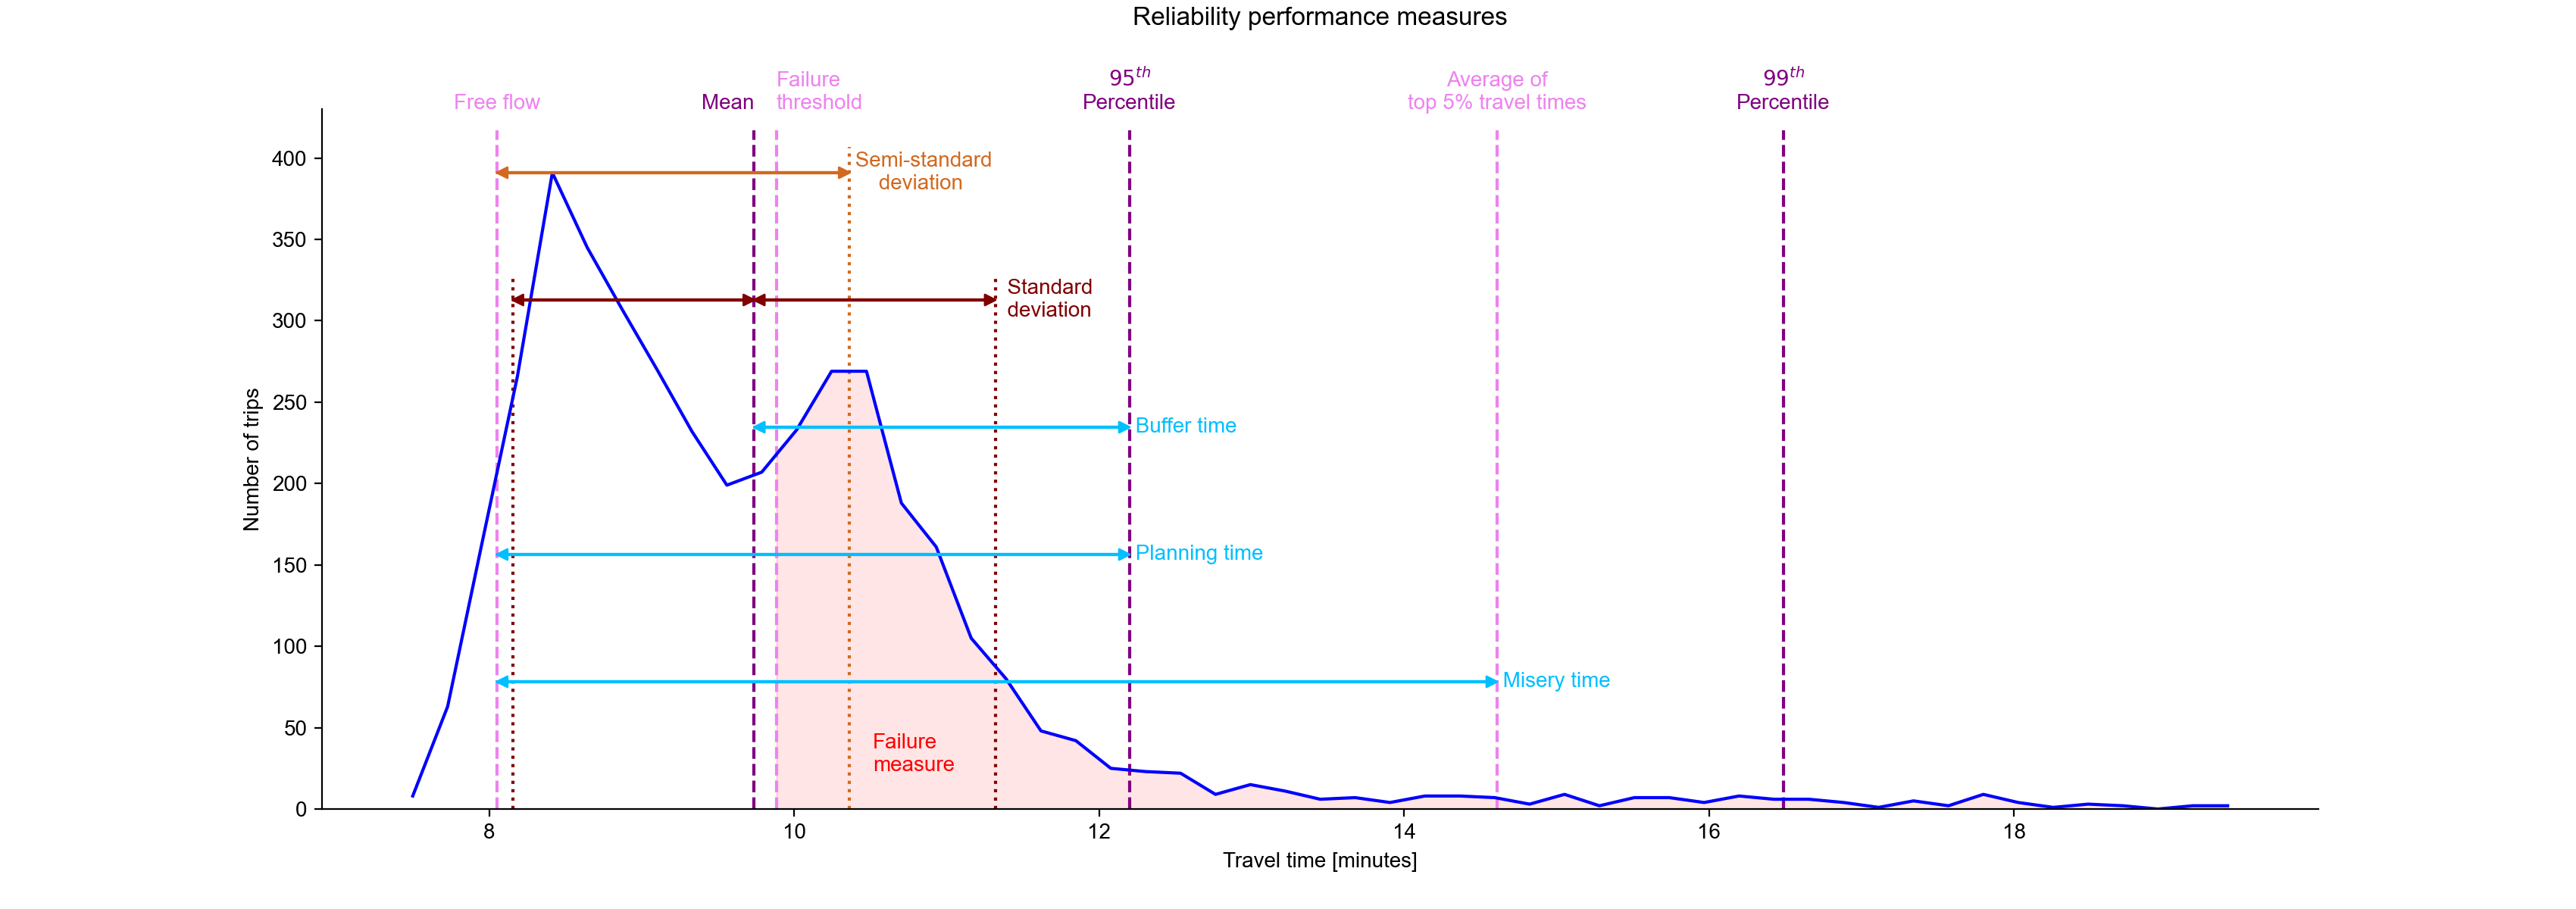

In [4]:
# initialization
plt.figure(num='Reliability performance measures')
ax = sns.histplot(data=df_route, x=x, element='poly',
                  fill=False, color=hist_col)

x_values = ax.get_lines()[0].get_data()[0]
y_values = ax.get_lines()[0].get_data()[1]
ymax = 1.1*y_values.max()
ax.set(ylim=(0, ymax))


# vertical lines

# free flow
vertical_line(free_flow, ymax, 'Free flow', 'center', v_col1)
# mean
vertical_line(x.mean(), ymax, 'Mean', 'right', v_col2)
# failure threshold
failure_threshold = .06*df_route['t_distance_[m]'].mean()/speed_threshold
vertical_line(failure_threshold, ymax, 'Failure\nthreshold', 'left', v_col1)
# 95th percentile
vertical_line(x.quantile(q=.95), ymax,
              '$95^{th}$\nPercentile', 'center', v_col2)
# average of top 5% travel times
vertical_line(x[x >= x.quantile(q=.95)].mean(), ymax,
              'Average of\ntop 5% travel times', 'center', v_col1)
# 99th percentile
vertical_line(x.quantile(q=.99), ymax,
              '$99^{th}$\nPercentile', 'center', v_col2)


# horizontal lines

# misery time
horitontal_line(free_flow, x[x >= x.quantile(q=.95)].mean(),
                y_values.max()/5, 'Misery time', times_col)
# planning time
horitontal_line(free_flow, x.quantile(q=.95),
                2*y_values.max()/5, 'Planning time', times_col)
# buffer time
horitontal_line(x.mean(), x.quantile(q=.95),
                3*y_values.max()/5, 'Buffer time', times_col)

# standard deviation
horitontal_line(x.mean()-x.std(), x.mean(), 4*y_values.max()/5, '', std_col)
horitontal_line(x.mean(), x.mean()+x.std(), 4*y_values.max()/5,
                ' Standard\n  deviation', std_col)
plt.vlines(x.mean()-x.std(), 0, 4.2*y_values.max()/5,
           color=std_col, linestyle='dotted')
plt.vlines(x.mean()+x.std(), 0, 4.2*y_values.max()/5,
           color=std_col, linestyle='dotted')

# semi-standard deviation
semi_std = np.sqrt(x.apply(lambda x: max(x-free_flow, 0)**2).sum()/len(x))
horitontal_line(free_flow, free_flow+semi_std, y_values.max(),
                'Semi-standard\n     deviation', semi_std_col)
plt.vlines(free_flow+semi_std, 0, 1.04*y_values.max(),
           color=semi_std_col, linestyle='dotted')


# shaded failure measure
failure_threshold_index = next((i for i, v in enumerate(
    x_values) if v > failure_threshold), len(x_values)-1)
x1 = x_values[failure_threshold_index-1]
x2 = x_values[failure_threshold_index]
y1 = y_values[failure_threshold_index-1]
y2 = y_values[failure_threshold_index]
k = (y2-y1)/(x2-x1)
failure_threshold_value = k*(failure_threshold-x2)+y2
plt.fill_between(np.append([failure_threshold], x_values[failure_threshold_index:]), 0,
                 np.append([failure_threshold_value], y_values[failure_threshold_index:]), color=fail_col, alpha=.1)
ax.annotate('Failure\nmeasure', xy=(
    x2+fail_offset, y2/fail_prop), color=fail_col)


# show plot
sns.set_style('ticks')
sns.despine()
plt.gcf().set_size_inches(fig_length, fig_height)
plt.title('Reliability performance measures', pad=40)
plt.xlabel('Travel time [minutes]')
plt.ylabel('Number of trips')
plt.show()
if save_fig:
    plt.savefig('rpm.pdf', bbox_inches='tight')